<h2 style="color:#73C6B6;">Appendix</h2>

1. <a href=#imports >Imports</a>
2. <a href=#function>Function</a> 
3. <a href=#load>Load Data</a>        
4. <a href=#formating>Data Formating </a>         
5. <a href=#valid>Validate Assumption(Optional)</a>        
6. <a href=#EDA>Exploratory Data Analysis</a>
7. <a href=#baseline_model>Baseline Model</a>
8. <a href=#data_prep>Data Prep and Experimentation</a>
9. <a href=#conclusion>Conclusion</a>

<h2 style="color:#73C6B6;"> OverView</h2>

<h2 style="color:#73C6B6;">Problem Statment</h2>

<h2 style="color:#73C6B6;"> Data Description </h2> 

<h2 style="color:#73C6B6;">Features </h2>

<h2 style="color:#73C6B6;">Tools </h2>

## <a name='imports' style="color:#73C6B6;">Libraries Imports</a> 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle
import pyarabic.araby as araby
from sklearn.model_selection import RandomizedSearchCV
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from pprint import pprint

In [131]:
# !pip install arabic_reshaper
# ! pip install python-bidi


## <a name='function' style="color:#73C6B6;">Function</a> 

In [132]:
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    text = re.sub(r'\ــ',' ',text)
    text = re.sub(r'[a-zA-Z]', '',text)
    return text

def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('Arabic')]
    return ' '.join(a)


def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text) # Remove longation
    return araby.strip_tashkeel(text)

def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    text = text.replace("ى", "ي")
    text = text.replace("ؤ", "ء")
    text = text.replace("ئ", "ء")
    text = text.replace("ة", "ه")
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text




def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
        
def remove_stop_words(text):
    zen = TextBlob(text)
    words = zen.words
    return " ".join([w for w in words if not w in all_stopwords and len(w) >= 2])
    #return " ".join([w for w in words if not w in stop_words and not w in stop_word_comp and len(w) >= 2])

# https://github.com/mohataher/arabic-stop-words
all_stopwords = list(set(stopwords.words("arabic"))) + pd.read_csv('Stopwords.txt').iloc[:, 0].values.tolist()



## <a name='load' style="color:#73C6B6;">Load Data</a> 

In [133]:
data = pd.read_csv('Prepared_Dataset.csv')

In [134]:
data

Unnamed: 0            ISBN  \
0               0      9774416333   
1               1   9789777195522   
2               2   9789777195331   
3               3             NaN   
4               4   9789777194693   
...           ...             ...   
16553       17864   9789957166984   
16554       17865   9789957163570   
16555       17866   9789957160951   
16556       17867   9789957160000   
16557       17868   9789957160000   

                                              Title  \
0                                     استمتع بحياتك   
1                                        عبقرية عمر   
2                                       عبقرية محمد   
3               لأنك الله : رحلة إلى السماء السابعة   
4                                 عبقرية الإمام علي   
...                                             ...   
16553       الوجيز في قانون أصول المحاكمات الجزائية   
16554           القضاء الجنائي الدولي في عالم متغير   
16555  اضطرابات الوسط الأسري وعلاقتها بجنوح الأحداث   
16556        النظرية العامة للجرائم ذات الخطر العام   
16557                               الجريمة المنظمة   

                             Author  Authors_Number  \
0           محمد عبد الرحمن العريفي             1.0   
1                 عباس محمود العقاد             1.0   
2                 عباس محمود العقاد             1.0   
3                علي بن جابر الفيفي             2.0   
4                 عباس محمود العقاد             1.0   
...                             ...             ...   
16553                 محمد صبحي نجم             1.0   
16554               علي يوسف الشكري             1.0   
16555             محمد سند العكايلة             1.0   
16556   عبد الباسط محمد سيف الحكيمي             1.0   
16557              كوركيس يوسف داود             1.0   

                                             Description  \
0      لما كنت فى السادسة عشرة من عمري وقع فى يدي كتا...   
1      يزخر التاريخ الإسلامي برجال عِظام سطروا حوادثه...   
2      احتفى التاريخ العربي بالسيرة المُحمدية؛ فأفرد ...   
3      كتاب يتحدث عن بعض أسماء الله الحسنى وكيف نعيشه...   
4      بَرَع «عباس محمود العقاد» في تناول شخصية الإما...   
...                                                  ...   
16553  يعرف قانون محاكمات الجزائية بانه مجموعة القواع...   
16554  مرّ القضاء الجنائي الدولي في تطوره بعدة مراحل،...   
16555  تعتبر هذه الدراسة ذات أهمية كبيرة لتناولها الم...   
16556  يقدم هذا الكتاب في الباب الأول الإطار النطري ل...   
16557  يلقي كتاب "الجريمة المنظمة" الضوء على هذه الظا...   

                            Genres Average_Ratings  Reviews_Number  \
0               علوم إسلامية رقائق             4.0            97.0   
1        علوم إسلامية سيرة الصحابة             4.1            64.0   
2      علوم إسلامية السيرة النبوية             4.3            45.0   
3               علوم إسلامية رقائق             4.7            83.0   
4        علوم إسلامية سيرة الصحابة             4.3            30.0   
...                            ...             ...             ...   
16553            قانون قانون جنائي             5.0             NaN   
16554            قانون قانون جنائي             4.0             NaN   
16555            قانون قانون جنائي             5.0             NaN   
16556            قانون قانون جنائي             4.5             1.0   
16557            قانون قانون جنائي               0             1.0   

       Quotes_Number  Community_Size  Pages_Number  Editions  \
0               39.0          7945.0           344         4   
1              114.0          7337.0           497         3   
2               62.0          4151.0           238         2   
3               99.0          3133.0           192         1   
4               25.0          2592.0            87         4   
...              ...             ...           ...       ...   
16553            NaN             8.0           576         1   
16554            NaN             8.0           320         1   
16555            NaN             8.0           334         1   
16556            NaN             8.0  

## <a name='formating' style="color:#73C6B6;">Data Formating </a> 

In [135]:
df=data[["Description","Title","Average_Ratings","Community_Size","Author","Genres",'Cover_URL']] # books = data[['Title', # books = data[['Title', 'Cover_URL']]]]

In [136]:
a = 2
for i in range(a,a+2):
    print(df.Description[i])
    print()

احتفى التاريخ العربي بالسيرة المُحمدية؛ فأفرد لها المجلدات الطوال، التي ذكرت أحداث ميلاد ونشأة النبي؛ وقد أسهبت في تناول أحداث حياته من المولد حتى الوفاة بتفاصيل كثيرة مُعززة بالأسانيد ومغرقة في تفاصيل الأحداث وتواريخها؛ ولما وضع العقاد هذا الكتاب لم يكن هدفه عرضًا جديدًا للسيرة المحمدية بل أراد إبراز ملامح 			ولد العقاد في أسوان في 28 يونيو 1889, وحصل على الشهادة الإبتدائية  في الرابعة عشر من عمره, و لم يكمل تعليمه بعدها. وحدث أن زار المدرسة الإمام الشيخ محمد عبده وعرض عليه مدرس اللغة العربية الشيخ فخر الدين كراسة التلميذ عباس العقاد، فتصفحها باسماً وناقش العقاد في موضوعاتها ثم عبقرية النبي الإنسان الذي اصطفاه الله بظروف مُختارة صَقَّلت شخصيته، وبقدرات إنسانية فذَّة مكَّنته من الاضطلاع بحمل الرسالة. كما يقدم لنا جوانب من حياة الداعي الرحيم، الرفيق بقومه، والعالم بما يصلح لهم، فكان القائد العسكري النبيل، والسياسي المحنَّك الذي استطاع كذلك أن يدبر أمور دولة الإسلام الوليدة بمهارة، كما يقترب من صفاته الإنسانية فهو الزوج العطوف والأب الحنون رغم جسامة المهمة التي لها أرسل.	 التفت إلى المدر

In [137]:
# a = 2
# for i in range(a,a+2):
#     print(df.Description_clean[i])
#     print()

In [138]:
# from farasa.segmenter import FarasaSegmenter
# segmenter = FarasaSegmenter(interactive=True)

# for index, i in enumerate(df['Description']):
#         text = segmenter.segment(i)     # segment all texts in Description
#         df['Description_clean'][index] = text

In [139]:
# a = 2
# for i in range(a,a+2):
#     print(df.Description_clean[i])
#     print()

In [140]:
df["Description_clean"] = df.Description.map(preprocess)


<ipython-input-140-2ceb5441747b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Description_clean"] = df.Description.map(preprocess)


In [141]:
# instantiate Farasa stemmer and preprocess text
from farasa.stemmer import FarasaStemmer 
stemmer = FarasaStemmer(interactive=True)

for index, i in enumerate(df["Description_clean"]):
        text = stemmer.stem(i)     # stemming
        df["Description_clean"][index] = text

[2021-12-29 09:17:45,236 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.
<ipython-input-141-10e9db1ac192>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Description_clean"][index] = text
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [142]:
### Common word removal
freq = pd.Series(' '.join(df['Description_clean']).split()).value_counts()[:12]
freq = list(freq.index)
df['Description_clean'] = df['Description_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
### Rare words removal
freq = pd.Series(' '.join(df['Description_clean']).split()).value_counts()[-50:]
freq = list(freq.index)
df['Description_clean'] = df['Description_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


<ipython-input-142-7c2f739e6d67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description_clean'] = df['Description_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
<ipython-input-142-7c2f739e6d67>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description_clean'] = df['Description_clean'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


In [143]:
a = 2
for i in range(a,a+2):
    print(df.Description_clean[i])
    print()

احتفى تاريخ عربي سيرة محمدي أفرد ل مجلد طويل ذكر حدث ميلاد نشأة نبي قد أسهب تناول حدث حياة مولد حتى وفاة تفصيل كثير معزز إسناد مغرق تفصيل حدث تاريخ لما وضع عقاد لم هدف عرض جديد سيرة محمدي بل أراد إبراز ملامح ولد عقاد أسوان يونيو حصل شهادة إبتدائي رابع عشر عمر و لم أكمل تعليم بعد حدث زار مدرسة إمام شيخ محمد عبده عرض مدرس لغة عربي شيخ فخر دين كراس تلميذ عباس عقاد تصفح باسم ناقش عقاد موضوع ثم عبقري نبي إنسان اصطفى الله ظرف مختار صقل شخصية قدرة إنسانية فذ مكن اضطلاع حمل رسالة كما قدم ل جانب حياة داعي رحيم رفيق قوم عالم صلح ل قائد عسكري نبيل سياسي محنك استطاع ذلك دبر أمر دولة إسلام وليدة مهارة كما اقترب صفة إنسانية هو زوج عطوف أب حنون رغم جسامة مهمة ل أرسل التفت مدرس قال أجدر فتى كاتب بعد و اشتغل وظيفة كثير مديرية مصلحة تلغراف و مصلحة سكة حديد و ديوان وقف و استقال واحد بعد واحد و قال وظيفة حكومي إن نفرة وظيفة حكومي مثل ذلك عهد قدس سابقة أغتبط ب أحمد الله لا أنسى حتى يوم تلقى خبر قبول وظيفة أول أكرهتني ظرف طلب كأن أتلقى خبر حكم سجن أو أسرة عبودي إذ أمن كل إيمان موظف رقيق قرن عشرون حياة سلسلة

In [144]:
from textblob import TextBlob
df['Description_clean'] =df['Description_clean'].apply(lambda x:remove_stop_words(x))


<ipython-input-144-0c89422ad418>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description_clean'] =df['Description_clean'].apply(lambda x:remove_stop_words(x))


In [145]:
df['Description_clean']

0        عمر وقع يد فن تعامل ناس مؤلف دايل كارنيجي رائع...
1        زخر تاريخ إسلامي رجل عظمة سطر حادث أكبر حرف نو...
2        احتفى تاريخ عربي سيرة محمدي أفرد مجلد طويل ذكر...
3        تحدث اسم الله أحسن عاش حياة حرص مؤلف مناسب متو...
4        برع عباس محمود عقاد تناول شخصية إمام ابن أب طا...
                               ...                        
16553    عرف قانون محاكمة جزائي مجموعة قاعدة شكلي حدد ن...
16554    مر قضاء جنائي دولي تطور مرحلة مرحلة مرحلة انعك...
16555    اعتبر دراسة أهمية كبير تناول موضوع الحاح وقت ح...
16556    قدم باب إطار نطري جريمة خطر موضح ماهية خطر معن...
16557    ألقى جريمة منظمة ضوء ظاهرة اجتماعي خطير عانى ا...
Name: Description_clean, Length: 16558, dtype: object

In [146]:
a = 10
for i in range(a,a+4):
    print(df.Description_clean[i])
    print()

إسلام شرق غرب بسيط أمكن قارئ تناول مسترخي اقتحم موضع قرأ صفحة صفحة ظن شيء قادر تقييم تصنيف نمط فكري مختلف قارئ جاد احتشد تهيأ دخول رئيس جمهوري بوسنة هرسك انتهاء حرب رهيب بوسنة ناشط سياسي بوسني فيلسوف إسلامي مؤلف كتب أهم إسلام شرق غرب ولد مدينة بوسان بوسني أسرة بوسني عريق إسلام اسم عائلة امتد وجود تركي بوسنة مقطع اسم عائلة نطق عالم ثري فكر متميز منهج أخاذ أسلوب منطق ثقافة صاحب عميق واسع مؤلف متمكن ثقافة إسلامي غربي معا مسلم نخاع أوربي مولد نشأة تعليم استوعب فكر غربي فرق جهل تجاهل مواطن جانب ضعف تناقض قصر استطاع عزت بيجو فيتش قدرة تحليلي طالع قارئ حقيقة إسلام مؤسسة تعليم تستلفت انتباه اتسق منهج تحليلي تقصي حقيقة هدف عبر قول فهم عالم صحيح عرف مصدر حقيقي فكر حكم عالم عرف معنى مؤلف فكر مفهوم جديد استخدم مصطلح مألوف معنى جديد مألوف تحدث دين شمل مصطلح إسلام أقصر مفهوم غربي سواء اتبع هدموه تعبير علاقة شخصية تأميلية إنسان رب شأن دنيا أمر حياة تحدث إسلام تحدث إطار فكرة جديد ابتدع فكرة وحدة ثنائي قطب ضم مركب جديد قضية متصادم منفصل عقل غربي روح مادة سماوي أرض إنساني حيواني دين دنيا ثنائي كامن طبيع

In [147]:
# import json
# import http.client
# limit_list =[]
# for text in df["poam_clean"]:
#     conn = http.client.HTTPSConnection("farasa-api.qcri.org")
#     payload = "{\"text\":\"%s\"}"% text
#     payload = payload.encode('utf-8')

#     headers = { 'content-type': "application/json", 'cache-control': "no-cache", }

#     conn.request("POST", "/msa/webapi/lemma", payload, headers)

#     res = conn.getresponse()

#     data = res.read()

#     limit_list.append(json.loads(data))
    
#df_new=pd.DataFrame.from_dict(limit_list)

## <a name='EDA' style="color:#73C6B6;">Exploratory Data Analysis</a>

In [392]:
import plotly.graph_objects as go
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['Description_clean'], 30)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'],marker_color='lightblue')])
fig.update_layout(title=go.layout.Title(text="Top 30 unigrams in description after removing stop words and lemmatization"))
fig.show()

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [148]:
#count vectorizer 
vectorizer = CountVectorizer(stopwords.words('Arabic'))    
data_vectorized = vectorizer.fit_transform(df['Description_clean'])


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input=['إذ', 'إذا', 'إذما', 'إذن', 'أف', 'أقل', 'أكثر', 'ألا', 'إلا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'إلى', 'إليك', 'إليكم', 'إليكما', 'إليكن', 'أم', 'أما', 'أما', 'إما', 'أن', 'إن', 'إنا', 'أنا', 'أنت', 'أنتم', 'أنتما', 'أنتن', 'إنما', 'إنه', 'أنى', 'أنى', 'آه', 'آها', 'أو', 'أولاء', 'أولئك', 'أوه', 'آي', 'أي', 'أيها', 'إي', 'أين', 'أين', 'أينما', 'إيه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل', '

In [149]:
# TfidfVectorizer
tfidf1 = TfidfVectorizer(stopwords.words('Arabic'))
Xtf = tfidf1.fit_transform(df['Description_clean'])


In [150]:
# CountVectorizer with ngram
vectorizer_ngram = CountVectorizer(ngram_range=(1, 2))    
data_vectorized_g = vectorizer_ngram.fit_transform(df['Description_clean'])

In [151]:
data_vectorized_g.shape

(16558, 889982)

In [152]:
#TfidfVectorizer with ngram
tfidf_ngram = TfidfVectorizer(ngram_range=(1, 2))
Xtf_g = tfidf_ngram.fit_transform(df['Description_clean'])

# Non-Negative Matrix Factorization (NMF)

In [153]:
# NMF by ues  countvectorizer 
for i in range(1,11):
    nmf_model = NMF(i)
    doc_topic_cv = nmf_model.fit_transform(data_vectorized)
    display_topics(nmf_model, vectorizer.get_feature_names(), 10)
    print ("--------------------------------------------------------")

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, فصل, عمل, دراسة, بحث, عالم, آخر, لغة, إسلامي, تناول
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, عمل, لغة, إسلامي, دراسة, عالم, جامعة, تاريخ, رواية, حياة

Topic  1
فصل, تناول, إدارة, قانون, عملية, مفهوم, دراسة, معلومة, عمل, علاقة
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, عمل, لغة, إسلامي, عالم, دراسة, جامعة, رواية, تاريخ, حياة

Topic  1
فصل, تناول, إدارة, مفهوم, عملية, معلومة, بحث, نظرية, عمل, دراسة

Topic  2
قانون, دولة, علاقة, دولي, عقد, حكم, مبحث, قانوني, حق, قاعدة
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, عمل, لغة, إسلامي, جامعة, رواية, دراسة, عالم, تاريخ, أدب

Topic  1
فصل, تناول, إدارة, مفهوم, عملية, معلومة, بحث, نظرية, عمل, موضوع

Topic  2
قانون, عقد, دولة, قانوني, حق, قاعدة, حكم, إداري, دولي, خاص

Topic  3
مدينة, علاقة, مبحث, دولة, أيوبي, ابن, حرب, عسكري, ملك, دولي
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, عمل, لغة, إسلامي, رواية, جامعة, عالم, دراسة, أدب, فن

Topic  1
فصل, تناول, إدارة, معلومة, عملية, مفهوم, بحث, عمل, نوع, موضوع

Topic  2
قانون, عقد, دولة, قانوني, حق, قاعدة, حكم, إداري, دولي, خاص

Topic  3
مدينة, علاقة, مبحث, دولة, ابن, أيوبي, حرب, ملك, عسكري, دولي

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, تربية, بحث, فكر, مفهوم, مبدأ
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عمل, رواية, حياة, عالم, كاتب, أدب, كتب, مدينة, آخر, كتابة

Topic  1
فصل, تناول, إدارة, معلومة, عملية, مفهوم, نظرية, بحث, نوع, موضوع

Topic  2
قانون, عقد, دولة, قانوني, قاعدة, حكم, حق, إداري, دراسة, دولي

Topic  3
عربي, إسلامي, فن, دراسة, لغة, بحث, عمارة, تراث, جامعة, فكر

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, تربية, بحث, فكر, مفهوم, دراسة

Topic  5
علاقة, مبحث, أيوبي, دولة, دولي, عسكري, دين, ملك, ابن, سياسي
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عمل, رواية, حياة, كاتب, عالم, أدب, كتب, آخر, كتابة, جامعة

Topic  1
فصل, تناول, إدارة, معلومة, مفهوم, عملية, بحث, نوع, موضوع, عمل

Topic  2
قانون, عقد, دولة, قانوني, قاعدة, حكم, حق, إداري, دراسة, دولي

Topic  3
عربي, إسلامي, فن, دراسة, لغة, بحث, عمارة, تراث, جامعة, تاريخ

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, تربية, بحث, فكر, دراسة, مفهوم

Topic  5
علاقة, مبحث, أيوبي, دولة, دولي, عسكري, دين, ملك, ابن, سياسي

Topic  6
مدينة, حضري, دراسة, منطقة, اجتماعي, دولة, عالم, شكل, مركز, ساكن
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
رواية, عمل, حياة, كاتب, أدب, عالم, كتب, كتابة, آخر, جامعة

Topic  1
فصل, تناول, بحث, عرض, دراسة, نوع, مفهوم, موضوع, عملية, نظرية

Topic  2
قانون, عقد, قانوني, دولة, حق, حكم, قاعدة, دراسة, تجاري, دولي

Topic  3
عربي, إسلامي, فن, دراسة, لغة, عمارة, تراث, بحث, تاريخ, فكر

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, بحث, تربية, فكر, دراسة, مبدأ

Topic  5
علاقة, مبحث, أيوبي, دولة, دولي, عسكري, دين, ملك, ابن, سياسي

Topic  6
مدينة, حضري, دراسة, منطقة, اجتماعي, دولة, عالم, شكل, مركز, ساكن

Topic  7
إدارة, معلومة, عمل, إلكتروني, منظمة, عملية, إداري, نظم, شكل, إنترنت
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
رواية, عمل, أدب, حياة, كاتب, كتب, كتابة, طفل, جامعة, عالم

Topic  1
فصل, تناول, عرض, نوع, مفهوم, عملية, موضوع, تحليل, طفل, تعريف

Topic  2
قانون, عقد, دولة, قانوني, حق, حكم, قاعدة, دولي, تجاري, جريمة

Topic  3
عربي, إسلامي, فن, لغة, دراسة, عمارة, تراث, جامعة, تاريخ, حضارة

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, تربية, فكر, ديموقراطية, مبدأ, مفهوم

Topic  5
علاقة, مبحث, أيوبي, دولة, دولي, عسكري, دين, ملك, ابن, سياسي

Topic  6
مدينة, حضري, دراسة, منطقة, دولة, اجتماعي, عالم, مركز, شكل, عراق

Topic  7
إدارة, عمل, معلومة, إداري, منظمة, عملية, نظم, هدف, مفهوم, نظام

Topic  8
بحث, دراسة, علمي, موضوع, آخر, نظرية, شكل, عالم, اجتماعي, مختلف
--------------------------------------------------------

Topic  0
رواية, عمل, أدب, كاتب, حياة, طفل, كتابة, كتب, قصة, جامعة

Topic  1
فصل, تناول, عرض, نوع, مفهوم, عملية, موضوع, تحليل, طفل, تعريف

Topic  2
قانون, عقد, دولة, قانوني, حق, قاعدة, حكم, دولي, تجاري, جريمة

Topic  3
عربي, إسلامي, فن, لغة, دراسة, عمارة, تراث, جامعة, فكر, تاريخ

Topic  4

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [170]:
 #NMF by ues  countvectorizer with ngram الافضل
nmf_model = NMF(15)
doc_topic = nmf_model.fit_transform(data_vectorized_g)
display_topics(nmf_model, vectorizer_ngram.get_feature_names(), 10)

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
رواية, عمل, حياة, كاتب, كتب, عالم, كتابة, آخر, قصة, نشر

Topic  1
فصل, تناول, عرض, تناول فصل, نوع, مفهوم, عملية, فصل تناول, موضوع, تحليل

Topic  2
عربي, إسلامي, فن, عمارة, تراث, عربي إسلامي, فنان, فكر, حضارة, معماري

Topic  3
قانون, دولة, حق, قانوني, دولي, قاعدة, جريمة, حكم, سلطة, إداري

Topic  4
فلسفة, تربوي, فلسفي, مدرسة, مضمون, مضمون تربوي, تربية, ديموقراطية, مبدأ, فكر

Topic  5
علاقة, مبحث, أيوبي, دولي, دين, ملك, عسكري, دولة, شام, فرنج

Topic  6
مدينة, حضري, دراسة, منطقة, اجتماعي, عالم, شكل, مركز, ساكن, أرض

Topic  7
إدارة, إداري, عمل, منظمة, هدف, عملية, مفهوم, تخطيط, قيادة, مورد

Topic  8
طفل, أدب, عمل, أدب طفل, كيلاني, مدرسة, مصري, قاهرة, منهج, عبقري

Topic  9
بحث, دراسة, علمي, نظرية, موضوع, اجتماعي, باحث, آخر, مختلف, مجال

Topic  10
ابن, الله, محمد, إسلامي, عبد, دين, شيخ, عالم, أب, مؤلف

Topic  11
عربي, لغة, جامعة, لغة عربي, دراسة, لغوي, أدب, درس, كلية, أستاذ

Topic  12
عراق, دولة, حرب, بغداد, عراقي, تاريخ, تعلم, بلد, عسكري, حكم

Topic  13
عقد, مسمى, عقد مسمى, إسلامي, 

In [155]:
doc_topic.shape

(16558, 15)

In [156]:
#NMF by use TfidfVectorizer
for i in range(1,11):
    nmf_model = NMF(i)
    doc_topic_tf = nmf_model.fit_transform(Xtf)
    display_topics(nmf_model, tfidf1.get_feature_names(), 10)
    print ("--------------------------------------------------------")

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, لغة, عمل, فصل, دراسة, جامعة, أدب, رواية, عالم, طفل
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, فصل, لغة, دراسة, عمل, عالم, تاريخ, جامعة, مؤلف, حياة

Topic  1
طفل, كيلاني, أدب, سكرتير, مصري, قاهرة, عبقري, قصة, عمل, مدرسة
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, رواية, جامعة, تاريخ, إسلامي, عالم, ابن, عمل, لغة, كتب

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, قصة, منهج

Topic  2
فصل, تناول, معلومة, إدارة, موضوع, قانون, دراسة, بحث, علمي, مفهوم
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, جامعة, لغة, إسلامي, تاريخ, دراسة, ابن, فلسفة, كلية, محمد

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, منهج, عمل

Topic  2
فصل, تناول, إدارة, معلومة, موضوع, قانون, مفهوم, بحث, عملية, مجال

Topic  3
رواية, حياة, قصة, كاتب, كتب, عمل, روائي, عالم, كتابة, نشر
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
إسلامي, جامعة, تاريخ, عربي, ابن, دراسة, فلسفة, محمد, دين, فكر

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, منهج, عمل

Topic  2
فصل, تناول, إدارة, معلومة, موضوع, قانون, مفهوم, عملية, مجال, بحث

Topic  3
رواية, قصة, حياة, كاتب, كتب, روائي, عمل, جائزة, نشر, حب

Topic  4
لغة, عربي, لغوي, قاعدة, كلمة, معجم, تعلم, طالب, مصطلح, تعليم
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
إسلامي, جامعة, تاريخ, عربي, ابن, دراسة, فلسفة, محمد, دين, فكر

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, عمل, منهج

Topic  2
فصل, إدارة, تناول, قانون, مفهوم, نظرية, دراسة, عملية, بحث, موضوع

Topic  3
جد, معلومة, شكر, طبق, كثير, صفة, قصة, رائع, مكتبة, شامل

Topic  4
لغة, عربي, لغوي, قاعدة, كلمة, طالب, معجم, تعلم, مصطلح, تعليم

Topic  5
رواية, حياة, كاتب, روائي, قصة, كتب, عمل, جائزة, نشر, محفوظ
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
إسلامي, جامعة, تاريخ, عربي, ابن, دراسة, محمد, فلسفة, دين, عبد

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, عمل, منهج

Topic  2
قانون, إدارة, مجال, عملية, نظرية, علمي, مختلف, موضوع, عمل, أمكن

Topic  3
جد, شكر, معلومة, مكتبة, قصة, شامل, دياب, افت, فأر, فار

Topic  4
لغة, عربي, لغوي, كلمة, قاعدة, معجم, طالب, تعلم, مصطلح, تعليم

Topic  5
رواية, كاتب, حياة, قصة, روائي, كتب, جائزة, نشر, عمل, محفوظ

Topic  6
فصل, تناول, مفهوم, إدارة, إعلام, باب, بحث, إلكتروني, اتصال, موضوع
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
إسلامي, جامعة, تاريخ, عربي, ابن, دراسة, فلسفة, محمد, دين, عبد

Topic  1
طفل, كيلاني, أدب, سكرتير, عبقري, قاهرة, مدرسة, مصري, عمل, منهج

Topic  2
قانون, إدارة, مجال, عملية, نظرية, عمل, مختلف, موضوع, علمي, أمكن

Topic  3
محمود, مصطفى, مسجد, طبي, طبيب, متحف, طب, مرض, توفى, ضم

Topic  4
لغة, عربي, لغوي, كلمة, قاعدة, معجم, طالب, تعلم, مصطلح, تعليم

Topic  5
رواية, حياة, كاتب, روائي, قصة, كتب, جائزة, نشر, عمل, كتابة

Topic  6
فصل, تناول, مفهوم, إدارة, إعلام, باب, بحث, إلكتروني, اتصال, موضوع

Topic  7
جد, شكر, معلومة, مكتبة, قصة, شامل, دياب, افت, فأر, فار
--------------------------------------------------------


/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
إسلامي, جامعة, عربي, تاريخ, ابن, دراسة, فلسفة, محمد, دين, عبد

Topic  1
كيلاني, طفل, أدب, سكرتير, عبقري, مصري, قاهرة, عمل, منهج, مدرسة

Topic  2
طفل, قصة, سلسلة, تربية, قصص, تربوي, روضة, مغامر, مرحلة, تعليم

Topic  3
قانون, إدارة, مجال, نظرية, عمل, عملية, موضوع, علمي, دراسة, مختلف

Topic  4
لغة, عربي, لغوي, كلمة, قاعدة, معجم, تعلم, طالب, تعليم, مصطلح

Topic  5
رواية, حياة, كاتب, روائي, كتب, عمل, نشر, جائزة, قصة, كتابة

Topic  6
فصل, تناول, مفهوم, إدارة, باب, إعلام, بحث, إلكتروني, اتصال, موضوع

Topic  7
جد, شكر, معلومة, مكتبة, شامل, دياب, افت, فار, فأر, ريف

Topic  8
محمود, مصطفى, مسجد, طبي, طبيب, متحف, طب, مرض, توفى, ضم
--------------------------------------------------------

Topic  0
إسلامي, تاريخ, جامعة, عربي, ابن, دراسة, محمد, فلسفة, دين, عبد

Topic  1
كيلاني, أدب, طفل, سكرتير, عبقري, مصري, قاهرة, عمل, منهج, مدرسة

Topic  2
طفل, قصة, سلسلة, تربية, قصص, تربوي, روضة, مغامر, مرحلة, أولى

Topic  3
مجال, حياة, علمي, أمكن, طريق, عملية, مختلف, إنسان, شكل, طبق

Topic  4
لغة, عربي

In [157]:
#NMF by use TfidfVectorizer with ngam 
nmf_model = NMF(10)
doc_topic_tf_g = nmf_model.fit_transform(Xtf_g)
display_topics(nmf_model, tfidf_ngram.get_feature_names(), 10)

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "



Topic  0
عربي, جامعة, لغة, إسلامي, عمل, تاريخ, دراسة, عالم, أدب, حياة

Topic  1
طفل, كيلاني, أدب طفل, أدب, سكرتير, عبقري, منهج, قاهرة, مدرسة, عمل

Topic  2
جد, شكر, شامل, معلومة, مكتبة, أصدر مكتبة, ريف غلاف, دياب مؤلف, لفت قصة, كثير أصدر

Topic  3
محمود, مصطفى, مصطفى محمود, مسجد, متحف, طبي, طبيب, توفى, دكتور مصطفى, ضم

Topic  4
فصل, تناول, إدارة, قانون, مفهوم, معلومة, موضوع, عملية, بحث, نظرية

Topic  5
كريستي, أجاثا, جريمة, رواية, أجاثا كريستي, نسخة, كتب, لغة حي, جريمة أفاد, قصة جريمة

Topic  6
عقاد, وظيفة, وظيفة حكومي, شيخ, مصلحة, حكومي, مدرس, خبر, عباس عقاد, عبده عرض

Topic  7
محفوظ, نجيب, نجيب محفوظ, رواية, نشر, بدأ نجيب, حارة, واقعي, ثلاثي, روائي

Topic  8
ابن, مؤلف, اسم, نشر, تاريخ, ولادة مؤلف, دائرة مكتبة, مسجل رقم, هاشمي مسجل, إيداع دائرة

Topic  9
رواية, طفل, سلسلة, مغامر, الله, أحمد خالد, خالد توفيق, لغز, سلسلة رواية, شاب


#  (LDA)

In [158]:
#Build LDA model by use  countvectorizer with ngram
lda_model = LatentDirichletAllocation(n_components=22,               # Number of topics
                                      max_iter=5,               # Max learning iterations
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model) 

LatentDirichletAllocation(max_iter=5, n_components=22, n_jobs=-1,
                          random_state=100)


In [159]:
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -13599668.74680464
Perplexity:  3189.946447752379
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 5,
 'mean_change_tol': 0.001,
 'n_components': 22,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [160]:
# #Tune number of topics apply LDA model by use countvectorizer ( RandomizedSearchCV)

# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.2, .3, .4]}
# # Init the Model
# lda = LatentDirichletAllocation()


# model = RandomizedSearchCV(lda, search_params,n_jobs=-1)


# model.fit(data_vectorized)

In [161]:
# best_lda_model_cv = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# pprint(best_lda_model_cv.get_params())

In [162]:
# #Build LDA model by use  TfidfVectorizer with ngram
# lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
#                                       max_iter=5,               # Max learning iterations
#                                       random_state=100,          # Random state
#                                       batch_size=128,            # n docs in each learning iter
#                                       evaluate_every = -1,       # compute perplexity every n iters, default: Don't
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )
# lda_output = lda_model.fit_transform(Xtf)

# print(lda_model) 

In [163]:
# print("Log Likelihood: ", lda_model.score(Xtf))

# # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
# print("Perplexity: ", lda_model.perplexity(Xtf))

# # See model parameters
# pprint(lda_model.get_params())

In [164]:
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=tfidf1, lda_model=lda_model, n_words=10)

In [165]:
topic_keywords

[array(['مصري', 'تاريخ', 'مصر', 'عمل', 'عربي', 'ولد', 'رحلة', 'مدرسة',
        'أدب', 'عصر'], dtype='<U43'),
 array(['حياة', 'رجل', 'فيلم', 'كاتب', 'آخر', 'جمال', 'سر', 'سينمائي',
        'سينما', 'حب'], dtype='<U43'),
 array(['فصل', 'إدارة', 'عمل', 'معلومة', 'عملية', 'تناول', 'مجال', 'وسيلة',
        'هدف', 'شكل'], dtype='<U43'),
 array(['فلسفة', 'فكر', 'فيلسوف', 'دين', 'فلسفي', 'عقل', 'عالم', 'معرفة',
        'الله', 'عمل'], dtype='<U43'),
 array(['جامعة', 'عربي', 'دراسة', 'إسلامي', 'لغة', 'أدب', 'كلية', 'أستاذ',
        'عمل', 'ثقافة'], dtype='<U43'),
 array(['رواية', 'نشر', 'محفوظ', 'عمل', 'كتب', 'حياة', 'نجيب', 'ولد',
        'كاتب', 'مصري'], dtype='<U43'),
 array(['عربي', 'حرب', 'عالم', 'تاريخ', 'حياة', 'عمل', 'آخر', 'مدينة',
        'حضارة', 'كتب'], dtype='<U43'),
 array(['فصل', 'دراسة', 'بحث', 'عربي', 'تناول', 'اجتماعي', 'علمي', 'نظرية',
        'موضوع', 'مفهوم'], dtype='<U43'),
 array(['سياحي', 'سياحة', 'زراعة', 'زراعي', 'شعر', 'عربي', 'منطقة', 'ماء',
        'صناعة', 'نبات'],

In [166]:
# #Tune number of topics apply LDA model by use TfidfVectorizer ( RandomizedSearchCV)

# search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.2, .3, .4]}
# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = RandomizedSearchCV(lda, search_params,n_jobs=-1)

# # Do the Grid Search
# model.fit(Xtf)

In [167]:
# best_lda_model_tf = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity

In [168]:
index =["سيرة الذاتية ومذكرات","مراجع وابحاث","فنون","قانون دولي","فلسفه","سياسه","اجتماعيه","روايات وقصص","مال واعمال","الاسره والطفل","تكنلوجيا والانترنت","سيره النبويه","دينيه","تاريخيه","ادب"]

In [272]:
# Show top n keywords for each topic

topic_keywords = show_topics(vectorizer=vectorizer_ngram, lda_model=nmf_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index =["روايات وقصص","مراجع وابحاث","فنون","قانون ","فلسفة","سياسة","اجتماعية","مال واعمال","الاسرة والطفل","تكنلوجيا والانترنت","سيرة النبوية","ادب","تاريخية","دينية","سيرة ذاتية ومذكرات"]
df_topic_keywords

Word 0    Word 1    Word 2     Word 3   Word 4  \
روايات وقصص          رواية       عمل      حياة       كاتب      كتب   
مراجع وابحاث           فصل     تناول       عرض  تناول فصل      نوع   
فنون                  عربي    إسلامي        فن      عمارة     تراث   
قانون                قانون      دولة        حق     قانوني     دولي   
فلسفة                فلسفة     تربوي     فلسفي      مدرسة    مضمون   
سياسة                علاقة      مبحث     أيوبي       دولي      دين   
اجتماعية             مدينة      حضري     دراسة      منطقة  اجتماعي   
مال واعمال           إدارة     إداري       عمل      منظمة      هدف   
الاسرة والطفل          طفل       أدب       عمل    أدب طفل   كيلاني   
تكنلوجيا والانترنت     بحث     دراسة      علمي      نظرية    موضوع   
سيرة النبوية           ابن      الله      محمد     إسلامي      عبد   
ادب                   عربي       لغة     جامعة   لغة عربي    دراسة   
تاريخية               عراق      دولة       حرب      بغداد    عراقي   
دينية                  عقد      مسمى  عقد مسمى     إسلامي      بنك   
سيرة ذاتية ومذكرات  معلومة  إلكتروني    إنترنت        نظم      عمل   

                         Word 5 Word 6      Word 7  Word 8  Word 9  
روايات وقصص                عالم  كتابة         آخر     قصة     نشر  
مراجع وابحاث              مفهوم  عملية   فصل تناول   موضوع   تحليل  
فنون                عربي إسلامي   فنان         فكر   حضارة  معماري  
قانون                     قاعدة  جريمة         حكم    سلطة   إداري  
فلسفة               مضمون تربوي  تربية  ديموقراطية    مبدأ     فكر  
سياسة                       ملك  عسكري        دولة     شام    فرنج  
اجتماعية                   عالم    شكل        مركز    ساكن     أرض  
مال واعمال                عملية  مفهوم       تخطيط   قيادة    مورد  
الاسرة والطفل             مدرسة   مصري       قاهرة    منهج   عبقري  
تكنلوجيا والانترنت      اجتماعي   باحث         آخر   مختلف    مجال  
سيرة النبوية                دين    شيخ        عالم      أب    مؤلف  
ادب                        لغوي    أدب         درس    كلية   أستاذ  
تاريخية                   تاريخ   تعلم         بلد   عسكري     حكم  
دينية                       حكم  قانون         عمل  قانوني   قاعدة  
سيرة ذاتية ومذكرات        صحافة    شكل        شبكة   إعلام   وسيلة

In [172]:
# nmf_output = nmf_model(data_vectorized_g)
# nmf_model.transform(doc_topic)

# # column names
# topicnames = ["سيرة الذاتية ومذكرات","مراجع وابحاث","فنون","قانون ","فلسفة","سياسة","اجتماعية","روايات وقصص","مال واعمال","الاسرة والطفل","تكنلوجيا والانترنت","سيرة النبوية","دينية","تاريخية","ادب"]


# # index names
# docnames = ["Doc" + str(i) for i in range(len(df))]

# # Make the pandas dataframe
# df_document_topic = pd.DataFrame(np.round(nmf_output, 2), columns=topicnames, index=docnames)

# # Get dominant topic for each document
# dominant_topic = np.argmax(df_document_topic.values, axis=1)
# df_document_topic['dominant_topic'] = dominant_topic

# # Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
# df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
# df_document_topics

In [173]:
# import json
# import http.client
# limit_list =[]
# for i,text in enumerate (df['Description_clean']):
#     conn = http.client.HTTPSConnection("farasa-api.qcri.org")
#     payload = "{\"text\":\"%s\"}"% text
#     payload = payload.encode('utf-8')
#     headers = { 'content-type': "application/json", 'cache-control': "no-cache", }
#     conn.request("POST", "/msa/webapi/lemma", payload, headers)
#     res = conn.getresponse()
#     data = res.read()
#     limit_list.append(json.loads(data))

In [174]:
#nmf_output = nmf_model.transform(doc_topic[:, :15])

In [356]:
H = pd.DataFrame(doc_topic.round(5),
             columns = ["سيرة الذاتية ومذكرات","مراجع وابحاث","فنون","قانون ","فلسفة","سياسة","اجتماعية","روايات وقصص","مال واعمال","الاسرة والطفل","تكنلوجيا والانترنت","سيرة النبوية","دينية","تاريخية","ادب"]
)
H

سيرة الذاتية ومذكرات  مراجع وابحاث     فنون   قانون     فلسفة    سياسة  \
0                   0.09442       0.00000  0.01135  0.03021  0.00000  0.01325   
1                   0.05481       0.00000  0.01568  0.03426  0.00000  0.00502   
2                   0.08012       0.01950  0.02404  0.00319  0.00601  0.00578   
3                   0.01715       0.00000  0.00000  0.00000  0.00000  0.00000   
4                   0.05286       0.02738  0.00000  0.00575  0.02236  0.00000   
...                     ...           ...      ...      ...      ...      ...   
16553               0.00000       0.01342  0.00000  0.14120  0.00000  0.00000   
16554               0.00000       0.00000  0.09351  0.29851  0.00000  0.17584   
16555               0.02020       0.04190  0.01957  0.03010  0.00000  0.00000   
16556               0.02973       0.04311  0.00000  0.17188  0.00000  0.00000   
16557               0.00000       0.24266  0.03686  0.14709  0.00000  0.01851   

       اجتماعية  روايات وقصص  مال واعمال  الاسرة والطفل  تكنلوجيا والانترنت  \
0       0.06228      0.00000     0.00000        0.13868             0.51478   
1       0.01092      0.02032     0.00150        0.00000             0.39985   
2       0.00000      0.02845     0.00000        0.00946             0.23327   
3       0.00000      0.00737     0.00601        0.05925             0.05748   
4       0.00000      0.03837     0.02306        0.00000             0.27823   
...         ...          ...         ...            ...                 ...   
16553   0.00000      0.00942     0.00000        0.04770             0.00345   
16554   0.00762      0.00000     0.00000        0.00000             0.00000   
16555   0.06416      0.03234     0.00000        0.13609             0.00736   
16556   0.00000      0.00000     0.00000        0.00870             0.00000   
16557   0.00000      0.05437     0.00000        0.00000             0.00000   

       سيرة النبوية    دينية  تاريخية      ادب  
0           0.08388  0.00000  0.01887  0.00000  
1           0.06900  0.02759  0.00000  0.00000  
2           0.10434  0.08038  0.00000  0.00163  
3           0.10963  0.00000  0.00211  0.00000  
4           0.08163  0.02001  0.00000  0.00000  
...             ...      ...      ...      ...  
16553       0.00000  0.00000  0.00615  0.01314  
16554       0.06463  0.38095  0.00000  0.10321  
16555       0.00000  0.00000  0.00947  0.05070  
16556       0.00000  0.00000  0.00000  0.03489  
16557       0.00493  0.00000  0.00000  0.01865  

[16558 rows x 15 columns]

In [357]:
from sklearn.metrics import silhouette_score
km = KMeans(n_clusters = 17)
km.fit(H)
silhouette_score(H, km.labels_)

0.3407065367839284

In [358]:
cluster=km.predict(H)

In [361]:
df_scaled=pd.DataFrame(km.cluster_centers_,columns=H.columns)
H["cluster"]=cluster

In [362]:
df_scaled

سيرة الذاتية ومذكرات  مراجع وابحاث       فنون    قانون       فلسفة  \
0           1.662220e-01      0.008544   0.040118  0.011314   0.017600   
1           4.111124e-02      0.064105   0.044935  0.031922   0.045283   
2           0.000000e+00      0.972720   0.053430  0.000000   0.000000   
3           8.127432e-03      0.027489   0.011706  0.002512   0.005438   
4           3.394733e-02      0.036490   0.021196  0.016011   0.026963   
5           0.000000e+00      0.000000  14.938950  0.000000   0.115350   
6           0.000000e+00      0.389190   0.000000  0.000000  12.181980   
7           3.738254e-02      0.031387   0.095866  0.018562   0.034643   
8          -6.938894e-18      0.355378   0.345712  0.090832   0.000000   
9           0.000000e+00      0.000000   0.000000  0.000000   0.000000   
10          2.233545e-02      0.555701   0.030818  0.012852   0.086402   
11          0.000000e+00      0.000000   0.000000  0.000000   0.000000   
12          5.111831e-02      0.015638   0.062357  0.012044   0.020706   
13          2.497531e-02      0.062126   0.023570  1.004372   0.023790   
14          4.560571e-02      0.507449   0.069504  0.036656   0.000000   
15          2.051818e-02      0.723335   0.050925  0.028345   0.038816   
16          1.603589e-02      0.013735   0.012895  0.011390   0.006661   

        سياسة      اجتماعية  روايات وقصص  مال واعمال  الاسرة والطفل  \
0    0.011081  2.554372e-02     0.015625    0.031012       0.025114   
1    0.028294  2.813468e-02     0.048745    0.015122       0.270146   
2    0.000000  1.393898e+01     0.105100    0.000000       0.000000   
3    0.004323  6.923784e-03     0.005124    0.807640       0.017280   
4    0.019091  2.469467e-02     0.005976    0.010552       0.047573   
5    0.000000  4.088500e-01     0.005450    0.000000       0.384490   
6    0.000000  0.000000e+00     0.000000    0.000000       0.000000   
7    0.013564  2.158151e-02     0.013071    0.024977       0.070834   
8    0.064296 -1.734723e-18     0.315940    0.000000       0.000080   
9   11.959950  4.588000e-02     0.000000    0.000000       0.000000   
10   0.090044  1.744424e-02     1.600522    0.009654       0.082614   
11   0.000000  4.564600e-01     0.115080    0.000000       0.000000   
12   0.016310  2.604170e-02     0.016973    0.021664       0.046598   
13   0.051833  1.015316e-02     0.095996    0.008218       0.092547   
14   0.021631  2.046429e-02     0.315727    0.000000       0.095586   
15   0.034540  2.406877e-02     0.098014    0.019973       0.110668   
16   0.004998  7.743289e-03     0.012119    0.008621       0.026154   

    تكنلوجيا والانترنت  سيرة النبوية         دينية   تاريخية       ادب  
0         3.103812e-02      0.081773  4.698249e-02  0.006967  0.016109  
1         2.909181e-02      0.055494  4.378212e-02  0.016274  0.075420  
2         0.000000e+00      0.000000  0.000000e+00  0.139690  0.000000  
3         1.050155e-02      0.054694  8.209662e-03  0.001152  0.008118  
4         1.146306e+00      0.056704  4.009700e-02  0.006399  0.014830  
5         0.000000e+00      0.000000  0.000000e+00  0.000000  0.000000  
6         0.000000e+00      0.000000  0.000000e+00  0.001370  0.000000  
7         4.301814e-02      0.393828  4.312188e-02  0.007330  0.023684  
8         1.233900e-01      0.034410 -3.469447e-18  4.846484  0.065406  
9         6.089200e-01      0.000000  0.000000e+00  0.000000  0.000000  
10        1.233212e-02      0.026641  7.700606e-03  0.016369  0.221996  
11        9.627000e-01      0.000000  1.104966e+01  0.118640  0.000000  
12        2.632509e-01      0.067115  4.062184e-02  0.012923  0.012544  
13        1.621551e-02      0.054471  4.946724e-02  0.083611  0.073153  
14        6.938894e-18      0.115920  5.257000e-02  0.025209  3.655496  
15        2.453310e-02      0.064464  5.353229e-02  0.025332  0.113100  
16        1.078846e-02      0.015868  1.143076e-02  0.005697  0.019374

In [368]:
df_scaled.to_csv("books.tsv",sep="\t")

In [ ]:
from PIL import Image
from wordcloud import ImageColorGenerator
result={'cluster':labels,'Description_clean':df.Description_clean}
result=pd.DataFrame(result)
for k in range(0,10):
    s=result[result.cluster==k]
    text=s['Description_clean'].str.cat(sep=' ')
    text = arabic_reshaper.reshape(text)
    text=' '.join([word for word in text.split()])
    text = get_display(text)
    font_file = './NotoNaskhArabic-Regular.ttf' # download from: https://www.google.com/get/noto
   
    wordcloud = WordCloud(font_path=font_file,max_font_size=5000, max_words=100, background_color="white").generate_from_text(text)
    print('Cluster: {}'.format(k))
    Description=books_cls[books_cls.cluster==k]['Description_clean']         
    
    plt.figure()
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [364]:
topic_keywords 

[array(['رواية', 'عمل', 'حياة', 'كاتب', 'كتب', 'عالم', 'كتابة', 'آخر',
        'قصة', 'نشر'], dtype='<U58'),
 array(['فصل', 'تناول', 'عرض', 'تناول فصل', 'نوع', 'مفهوم', 'عملية',
        'فصل تناول', 'موضوع', 'تحليل'], dtype='<U58'),
 array(['عربي', 'إسلامي', 'فن', 'عمارة', 'تراث', 'عربي إسلامي', 'فنان',
        'فكر', 'حضارة', 'معماري'], dtype='<U58'),
 array(['قانون', 'دولة', 'حق', 'قانوني', 'دولي', 'قاعدة', 'جريمة', 'حكم',
        'سلطة', 'إداري'], dtype='<U58'),
 array(['فلسفة', 'تربوي', 'فلسفي', 'مدرسة', 'مضمون', 'مضمون تربوي',
        'تربية', 'ديموقراطية', 'مبدأ', 'فكر'], dtype='<U58'),
 array(['علاقة', 'مبحث', 'أيوبي', 'دولي', 'دين', 'ملك', 'عسكري', 'دولة',
        'شام', 'فرنج'], dtype='<U58'),
 array(['مدينة', 'حضري', 'دراسة', 'منطقة', 'اجتماعي', 'عالم', 'شكل',
        'مركز', 'ساكن', 'أرض'], dtype='<U58'),
 array(['إدارة', 'إداري', 'عمل', 'منظمة', 'هدف', 'عملية', 'مفهوم', 'تخطيط',
        'قيادة', 'مورد'], dtype='<U58'),
 array(['طفل', 'أدب', 'عمل', 'أدب طفل', 'كيلاني', 'مدرس

In [177]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16558 entries, 0 to 16557
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Description        16558 non-null  object 
 1   Title              16558 non-null  object 
 2   Average_Ratings    16558 non-null  object 
 3   Community_Size     15777 non-null  float64
 4   Author             16550 non-null  object 
 5   Genres             15178 non-null  object 
 6   Cover_URL          16554 non-null  object 
 7   Description_clean  16558 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.0+ MB


In [178]:
df['Average_Ratings']=pd.to_numeric(df['Average_Ratings'], errors='coerce')

<ipython-input-178-83a1944c69fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average_Ratings']=pd.to_numeric(df['Average_Ratings'], errors='coerce')


In [179]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16558 entries, 0 to 16557
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Description        16558 non-null  object 
 1   Title              16558 non-null  object 
 2   Average_Ratings    16557 non-null  float64
 3   Community_Size     15777 non-null  float64
 4   Author             16550 non-null  object 
 5   Genres             15178 non-null  object 
 6   Cover_URL          16554 non-null  object 
 7   Description_clean  16558 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.0+ MB


In [180]:
# Calculate mean of vote average column
C = df['Average_Ratings'].mean()
print(C)

3.1499607416802835


In [181]:
# Calculate the minimum number of votes required to be in the chart, m
m = df['Average_Ratings'].quantile(0.90)
print(m)

5.0


In [182]:
# Filter out all best rating books into a new DataFrame
b_books = df.copy().loc[df['Average_Ratings'] >= m]
b_books.shape

(3448, 8)

In [183]:
# Function that computes the weighted rating of each book
def weighted_rating(x, m=m, C=C):
    v = x['Community_Size']
    R = x['Average_Ratings']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [184]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
b_books['score'] = b_books.apply(weighted_rating, axis=1)

In [185]:
#Sort books based on score calculated above
b_books = b_books.sort_values('score', ascending=False)

#Print the top 15 books
b_books[["Title","Average_Ratings","Community_Size",'score']].head(20)

Title  Average_Ratings  \
6417                           ابن الرومي: حياته من شعره              5.0   
8058                                  اسرار علم الشخصيات              5.0   
12953                              تاريخ الفلسفة الحديثة              5.0   
2567   الأمثال العامية: مشروحة ومرتبة حسب الحرف الأول...              5.0   
2589                           روكامبول #16: مذكرة مجنون              5.0   
6434                                           قصة حياتي              5.0   
2619                              روكامبول #5: سجن طولون              5.0   
2628                                         في أثر غيمة              5.0   
10955                     قصة الأصل: تاريخ جامع لكلّ شيء              5.0   
2651                                     حدائقهن المعلقة              5.0   
54                                        الآثار النبوية              5.0   
10956                                     الآثار النبوية              5.0   
8078                                         وجوه القائد              5.0   
2684                                          الأكواريوم              5.0   
2693                                             الشاردة              5.0   
4571                                       آخر برميل نفط              5.0   
362                                فلسفاتُ الحياة الثلاث              5.0   
2778                                     نوادر العُشَّاق              5.0   
3885                                      الصَّدِيقَتانِ              5.0   
10967  موسوعة مصر القديمة (الجزء الثاني): في مدنية مص...              5.0   

       Community_Size     score  
6417            419.0  4.978183  
8058            295.0  4.969166  
12953           283.0  4.967881  
2567            277.0  4.967198  
2589            262.0  4.965355  
6434            250.0  4.963725  
2619            244.0  4.962851  
2628            239.0  4.962089  
10955           230.0  4.960637  
2651            228.0  4.960300  
54              225.0  4.959782  
10956           225.0  4.959782  
8078            210.0  4.956976  
2684            208.0  4.956572  
2693            203.0  4.955528  
4571            187.0  4.951822  
362             177.0  4.949175  
2778            175.0  4.948610  
3885            167.0  4.946220  
10967           165.0  4.945587

In [186]:
tfidf1.get_feature_names()[5000:5010]

['إطراد',
 'إطروح',
 'إطعام',
 'إطفاء',
 'إطفائي',
 'إطلاع',
 'إطلاق',
 'إطلاقية',
 'إطلال',
 'إطلس']

In [187]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(Xtf, Xtf)

In [188]:
cosine_sim.shape

(16558, 16558)

In [189]:
cosine_sim[1]

array([0.10512032, 1.        , 0.56952572, ..., 0.01991786, 0.0210838 ,
       0.01307532])

In [190]:
#Construct a reverse map of indices and books titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

In [191]:
indices[:10]

Title
استمتع بحياتك                          0
عبقرية عمر                             1
عبقرية محمد                            2
لأنك الله : رحلة إلى السماء السابعة    3
عبقرية الإمام علي                      4
حوار مع صديقي الملحد                   5
المرأة في الجاهلية                     6
التفكير فريضة إسلامية                  7
عبقرية الصديق                          8
حياة محمد                              9
dtype: int64

In [276]:
# Function that takes in books title as input and outputs most similar books
from PIL import Image
import requests
from io import BytesIO
import arabic_reshaper

def get_recommendations(title,cosine_sim=cosine_sim):
    # Get the index of the books that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the books based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar books
    sim_scores = sim_scores[1:11]

    # Get the book indices
    book_indices = [i[0] for i in sim_scores]
    recommend = df.iloc[book_indices]

    for index, row in recommend.iterrows():
        response = requests.get(row['Cover_URL'])
        img = Image.open(BytesIO(response.content))
        plt.figure()
        plt.imshow(img) 
        text=row['Title']
        text = arabic_reshaper.reshape(text)
        text = get_display(text)
        plt.axis("off")
        plt.title(text)
        

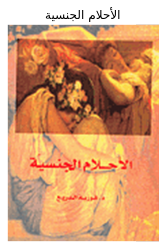

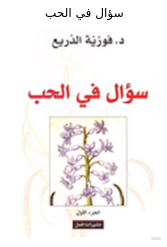

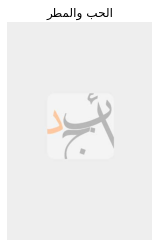

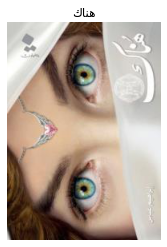

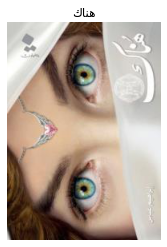

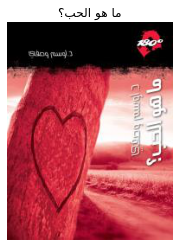

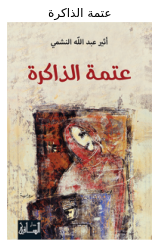

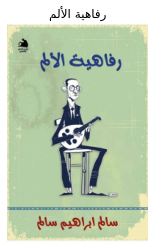

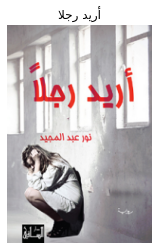

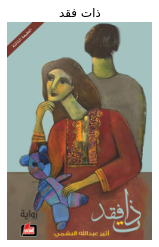

In [277]:
get_recommendations("أحببتك أكثر مما ينبغي")

In [297]:

# def recommendations(Title,Author,Genres,cosine_sim=cosine_sim):
#     # Get the index of the books that matches the title
#     idx = indices[Title,Author,Genres]

#     # Get the pairwsie similarity scores of all books with that book
#     sim_scores = list(enumerate(cosine_sim[idx]))

#     # Sort the books based on the similarity scores
#     sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

#     # Get the scores of the 10 most similar books
#     sim_scores = sim_scores[1:11]

#     # Get the book indices
#     book_indices = [i[0] for i in sim_scores]
#     recommend = df.iloc[book_indices]

#     for index, row in recommend.iterrows():
#         response = requests.get(row['Cover_URL'])
#         img = Image.open(BytesIO(response.content))
#         plt.figure()
#         plt.imshow(img) 
#         text=row['Title']
#         text = arabic_reshaper.reshape(text)
#         text = get_display(text)
#         plt.axis("off")
#         plt.title(text)
     

In [194]:
# Title, Author, and Genres Based Recommender
# Create a new soup feature
df['soup'] = df['Title'].astype(str)+' '+df['Author']+' '+df['Genres']

<ipython-input-194-1fdc884beda8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['soup'] = df['Title'].astype(str)+' '+df['Author']+' '+df['Genres']


In [195]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(data_vectorized, data_vectorized)

In [196]:
# Reset index of your main DataFrame and construct reverse mapping as before
df = df.reset_index()
indices1 = pd.Series(df.index, index=df['Title'])

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



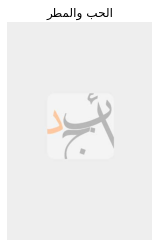

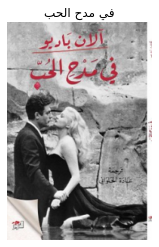

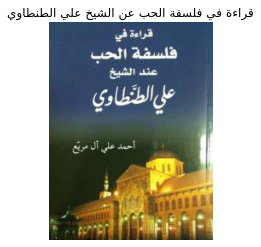

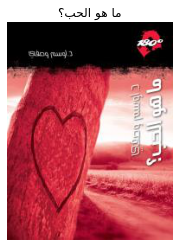

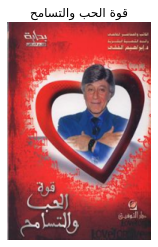

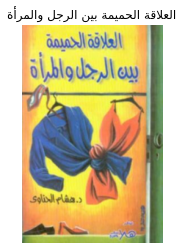

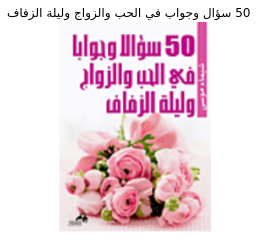

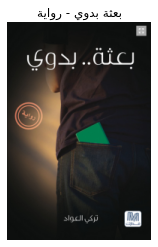

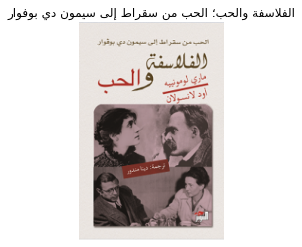

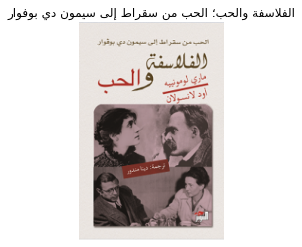

In [386]:
get_recommendations('سؤال في الحب', cosine_sim2)

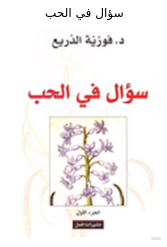

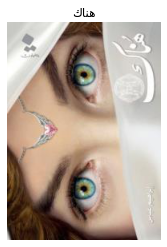

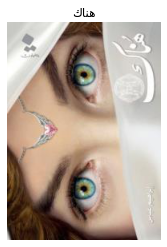

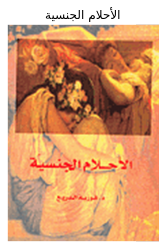

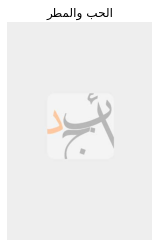

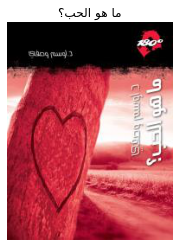

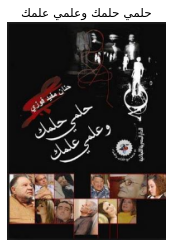

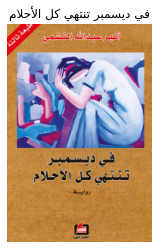

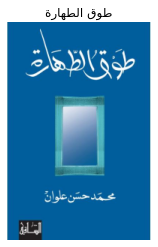

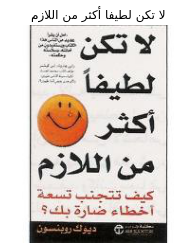

In [275]:
get_recommendations('أحببتك أكثر مما ينبغي', cosine_sim2)

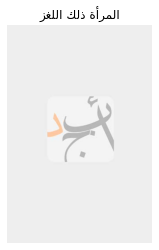

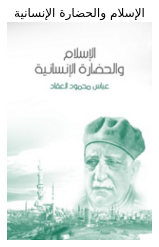

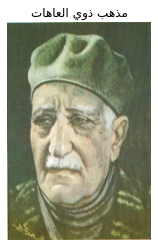

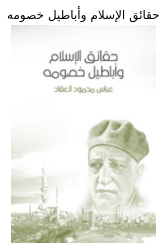

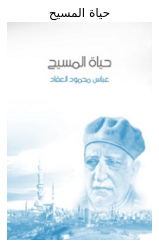

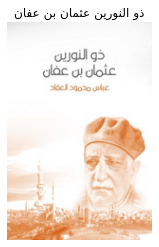

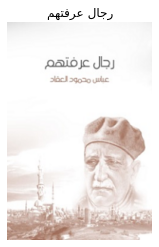

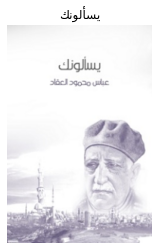

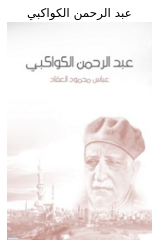

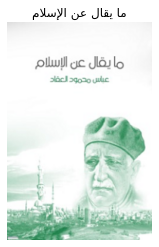

In [254]:
get_recommendations('داعي السماء بلال بن رباح', cosine_sim2)

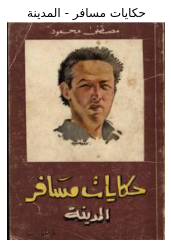

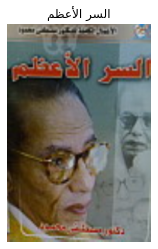

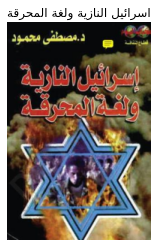

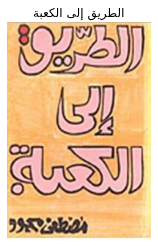

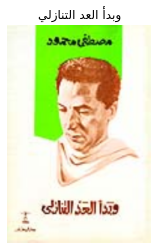

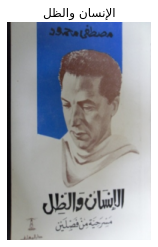

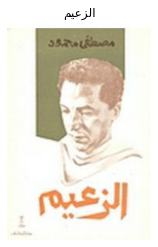

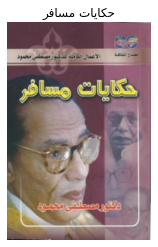

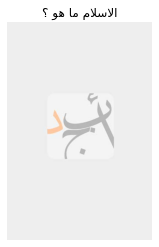

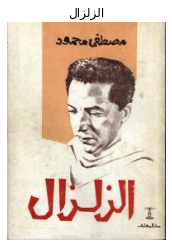

In [255]:
get_recommendations("حوار مع صديقي الملحد", cosine_sim2)

In [200]:
# books = data[['Title', 'Cover_URL']]

In [201]:
# from PIL import Image
# import requests
# from io import BytesIO
# def recommendations(title):

    
#     # finding cosine similarity for the vectors

#     cosine_similarities = cosine_similarity(data_vectorized, data_vectorized)

#     # taking the title and book image link and store in new data frame called books
#     books =data[['Title', 'Cover_URL']]
#     #Reverse mapping of the index
#     indices = pd.Series(data.index, index = data['Title']).drop_duplicates()
         
#     idx = indices[title]
#     sim_scores = list(enumerate(cosine_similarities[idx]))
#     sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
#     sim_scores = sim_scores[1:6]
#     book_indices = [i[0] for i in sim_scores]
#     recommend = books.iloc[book_indices]

#     for index, row in recommend.iterrows():
#         response = requests.get(row['Cover_URL'])
#         img = Image.open(BytesIO(response.content))
#         plt.figure()
#         plt.imshow(img)
#         plt.title(row['Title'])

In [202]:
# recommendations('الإسلام بين الشرق والغرب')

In [203]:
!pip install arabic-reshaper

In [204]:
wcss = [] #Within cluster sum squares countvectorized
for i in range(2,15):
    km = KMeans(n_clusters= i, random_state=45)
    km.fit(data_vectorized_g)
    wcss.append(km.inertia_)

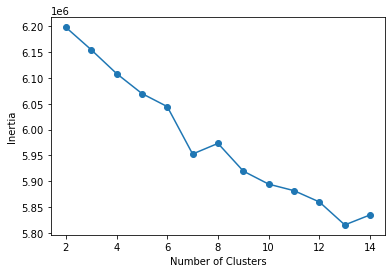

In [205]:
plt.plot(list(range(2,15)),wcss)
plt.scatter(list(range(2,15)),wcss)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [206]:
km_v_ngram = KMeans(n_clusters= 10, random_state=45)
km_v_ngram.fit(data_vectorized_g)
km_v_ngram.inertia_
labels=km_v_ngram.labels_

In [207]:
books_cl=pd.DataFrame(list(zip(df.Description_clean,labels)),columns=['Description_clean','cluster'])

In [208]:
books_cl.sort_values(by=['cluster'])

Description_clean  cluster
4905   منظمة عمل اختلاف نشاط صناعي خدمي عمل استمرار ت...        0
2917   عد منهج بحث إعلامي منهج علمي حديث عهد بدأ استخ...        0
5191   عزيز قارئ محاولة إلقاء ضوء مجال نظم معاونة اتخ...        0
4758   خلق الله عز جل خلق فضل إنسان سائر مخلوق عقل قد...        0
4759   تطلع منظمة تعظيم ربحي زيادة فاعلية إنتاجية است...        0
...                                                  ...      ...
16052  عد عقد مسمى عقد شيوع تداول فرد تعامل جرى اصطلا...        8
16063  درج فقيه قانون مدني تقسيم عقد مسمى مسمى قصد عق...        8
16107  أراد عقد مسمى عقد تولى قانون تنظيم اسم معين نظ...        8
15915  عقد مسمى عقد مسمى أثر تطور اقتصادي اجتماعي ظهو...        8
11509  مرحلة عاصفة مرحلة تاريخ علمي هاجم أوربا أرض شا...        9

[16558 rows x 2 columns]

In [209]:
inertia = [] #Within cluster sum squares
for i in range(2,25):
    km_tf = KMeans(n_clusters= i, random_state=45,n_jobs=-1)
    km_tf.fit(Xtf)
    inertia.append(km_tf.inertia_)

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' 

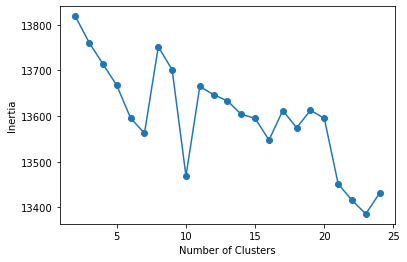

In [210]:
plt.plot(list(range(2,25)),inertia)
plt.scatter(list(range(2,25)),inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [211]:
km_tf_ngram = KMeans(n_clusters=10 , random_state=45)
km_tf_ngram.fit(Xtf) 
km_tf_ngram.inertia_
labels1=km_tf_ngram.labels_

In [212]:
books_cls=pd.DataFrame(list(zip(df.Description_clean,labels1)),columns=['Description_clean','cluster'])

In [213]:
books_cls.sort_values(by=['cluster'])

Description_clean  cluster
0      عمر وقع يد فن تعامل ناس مؤلف دايل كارنيجي رائع...        0
12249  رحلة خبر مدينة حكى خبر شهر رحال مسلم زار مصر ب...        0
12250  فريد حمل محمد مخزنجي لغة أديب فضول صحفي بلد بع...        0
1246   رفع معجم وقع قبيلة أسرة مصري حديث ارتياد دار ع...        0
12253  صعب مرء افتتن صحراء أثار خيال أيقظ وجدان مشعر ...        0
...                                                  ...      ...
6709   احتل إسرائيل ضفة غربي أساس مطران قدس إيلاريون ...        9
6710   حائز جائزة نوبل أدب خبر وحيد كتب بوب ديل فائز ...        9
6715   وقوف سر سلوكي رجل إلهي توصل سر رسم صورة عرفاني...        9
6689   دعا صحافي نبيل ملحم حوار أجرى أوج آلان ذاكرة ج...        9
8278   سلط كاتب ضوء ناحية مهمل علاقة إنسانية تكريس ان...        9

[16558 rows x 2 columns]

In [214]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

Cluster: 0


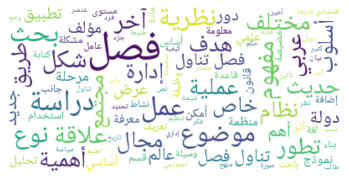

Cluster: 1


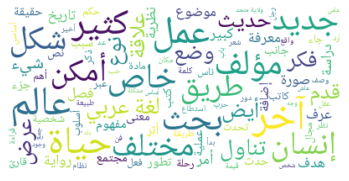

Cluster: 2


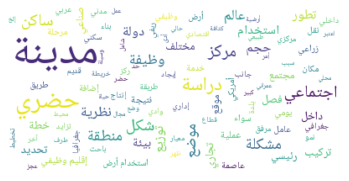

Cluster: 3


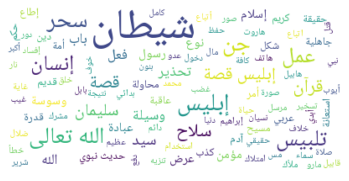

Cluster: 4


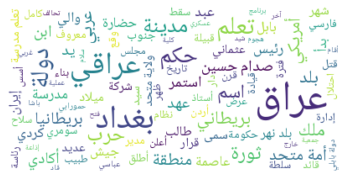

Cluster: 5


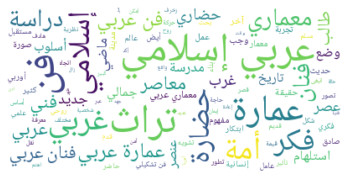

Cluster: 6


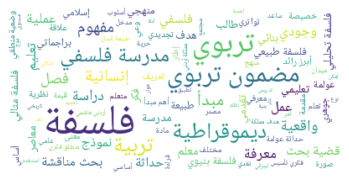

Cluster: 7


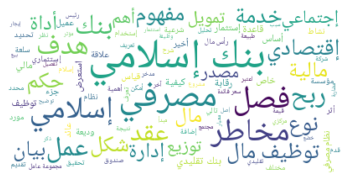

Cluster: 8


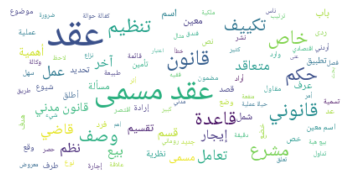

Cluster: 9


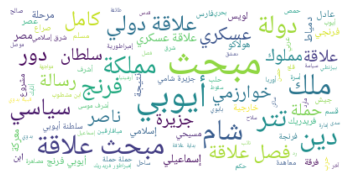

In [215]:
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
result={'cluster':labels,'Description_clean':df.Description_clean}
result=pd.DataFrame(result)
for k in range(0,10):
    s=result[result.cluster==k]
    text=s['Description_clean'].str.cat(sep=' ')
    text = arabic_reshaper.reshape(text)
    text=' '.join([word for word in text.split()])
    text = get_display(text)
    font_file = './NotoNaskhArabic-Regular.ttf' # download from: https://www.google.com/get/noto
    wordcloud = WordCloud(font_path=font_file,max_font_size=50, max_words=100, background_color="white").generate_from_text(text)
    print('Cluster: {}'.format(k))
   
    Description=books_cl[books_cl.cluster==k]['Description_clean']         
    
    plt.figure()
    
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [387]:
# from PIL import Image
# from wordcloud import ImageColorGenerator
# result={'cluster':labels,'Description_clean':df.Description_clean}
# result=pd.DataFrame(result)
# for k in range(0,10):
#     s=result[result.cluster==k]
#     text=s['Description_clean'].str.cat(sep=' ')
#     text = arabic_reshaper.reshape(text)
#     text=' '.join([word for word in text.split()])
#     text = get_display(text)
#     font_file = './NotoNaskhArabic-Regular.ttf' # download from: https://www.google.com/get/noto
#     mask = np.array(Image.open("كــــــتــــــاب (1).png"))
#     wordcloud = WordCloud(font_path=font_file,max_font_size=5000, max_words=100, background_color="white", mask=mask).generate_from_text(text)
#     print('Cluster: {}'.format(k))
#     image_colors = ImageColorGenerator(mask)
#     Description=books_cls[books_cls.cluster==k]['Description_clean']         
    
#     plt.figure()
    
#     plt.imshow(wordcloud, interpolation="bilinear")
#     plt.axis("off")
#     plt.show()

/Users/raghadm/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

